## Bayesian Statistics with Linear Regression

For Bayesian modeling, probabilistic programming allows us to use the data to go back and pick one of many possible parameters as the most likely to have created the data, namely the posterior distribution of parameters. The posterior distribution is P(A|B), which is what we are calculating. Probabilistic programming allows us to calculate those probabilities by taking integrals, which enables us to solve for Bayes' Theorem. You want to estimate your parameters (coefficients), like linear regression.  The probability distributions are your coefficient estimates. In python's pymc3 library, samples are "traces". You will see the shape of your distribution.  

In [1]:
#source:  https://docs.pymc.io/notebooks/GLM-linear.html
        
%matplotlib inline
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Create Simulated Data

In [2]:
# We will create a data set with 200 observation and set b0=1 and b1=2.
size = 200
true_intercept = 1
true_slope = 2

In [3]:
# Create data
x = np.linspace(0, 1, size)
x

array([0.        , 0.00502513, 0.01005025, 0.01507538, 0.0201005 ,
       0.02512563, 0.03015075, 0.03517588, 0.04020101, 0.04522613,
       0.05025126, 0.05527638, 0.06030151, 0.06532663, 0.07035176,
       0.07537688, 0.08040201, 0.08542714, 0.09045226, 0.09547739,
       0.10050251, 0.10552764, 0.11055276, 0.11557789, 0.12060302,
       0.12562814, 0.13065327, 0.13567839, 0.14070352, 0.14572864,
       0.15075377, 0.15577889, 0.16080402, 0.16582915, 0.17085427,
       0.1758794 , 0.18090452, 0.18592965, 0.19095477, 0.1959799 ,
       0.20100503, 0.20603015, 0.21105528, 0.2160804 , 0.22110553,
       0.22613065, 0.23115578, 0.2361809 , 0.24120603, 0.24623116,
       0.25125628, 0.25628141, 0.26130653, 0.26633166, 0.27135678,
       0.27638191, 0.28140704, 0.28643216, 0.29145729, 0.29648241,
       0.30150754, 0.30653266, 0.31155779, 0.31658291, 0.32160804,
       0.32663317, 0.33165829, 0.33668342, 0.34170854, 0.34673367,
       0.35175879, 0.35678392, 0.36180905, 0.36683417, 0.37185

### Bayesian Linear Regression Model

We want to fit a Bayesian linear regression model, using the glm module. 

In [4]:
# Linear Regression Model
# y = b0 + b1*x
true_regression_line = true_intercept + true_slope * x

In [5]:
# add noise
y = true_regression_line + np.random.normal(scale=.5, size=size)

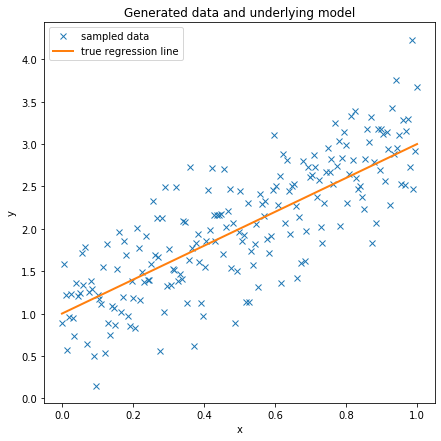

In [6]:
# Scatter plot and linear regression line
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(x, y, 'x', label='sampled data')
ax.plot(x, true_regression_line, label='true regression line', lw=2.0)
plt.legend(loc=0);

In [7]:
# Build model
with pm.Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.0)
    intercept = pm.Normal('Intercept', 0, sigma=20)
    x_coeff = pm.Normal('x', 0, sigma=20)
    
    # Define likelihood
    likelihood = pm.Normal('y', mu=intercept + x_coeff * x, 
                        sigma=sigma, observed=y)
    
    # Inference, 3000 draws and 2 chains
    trace = pm.sample(3000, cores=2) # draw 3000 posterior samples using NUTS sampling
    # NUTS is a next-generation Markov chain Monte Carlo (MCMC) sampling alogorithm

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x, Intercept, sigma]
Sampling 2 chains: 100%|██████████| 7000/7000 [00:19<00:00, 352.16draws/s]
The acceptance probability does not match the target. It is 0.8816197226981225, but should be close to 0.8. Try to increase the number of tuning steps.


A chain is a single run of MCMC. 

In [8]:
# create a dataframe
ds = {'x':x, 'y':y}
data = pd.DataFrame(ds)
data.head()

,x,y
0,0.000000,0.887838
1,0.005025,1.587353
2,0.010050,1.214077
3,0.015075,0.574839
4,0.020101,0.959647


In [9]:
# GLM
with pm.Model() as model:
    
    # specify glm and pass in data. The resulting linear model, its likelihood and 
    # and all its parameters are automatically added to our model.
    pm.glm.GLM.from_formula('y ~ x', data=data)
    
    # number of independent draws and independent chains
    trace = pm.sample(3000, cores=2) # draw 3000 posterior samples using NUTS sampling

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, x, Intercept]
Sampling 2 chains: 100%|██████████| 7000/7000 [00:19<00:00, 363.32draws/s]


In [10]:
# summary of the posterior distribution for each parameter
pm.summary(trace)

/Users/karenyang/opt/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,0.960533,0.063266,0.001237,0.840425,1.086059,2964.539044,0.999978
x,2.118439,0.109837,0.002197,1.902575,2.336109,2919.149942,0.999912
sd,0.456111,0.022721,0.000404,0.413758,0.501705,3960.151453,0.999843


In the table above, some of the key columns to look at are n_eff and Rhat. Here, n_eff shows an estimate of the number of effective (or independent) samples for that parameter. Rhat shows the Gelman–Rubin statistic and it should be close to 1.

### Posterior Plots and Regression Lines

We can see the simulated posterior distribution below.

<Figure size 504x504 with 0 Axes>

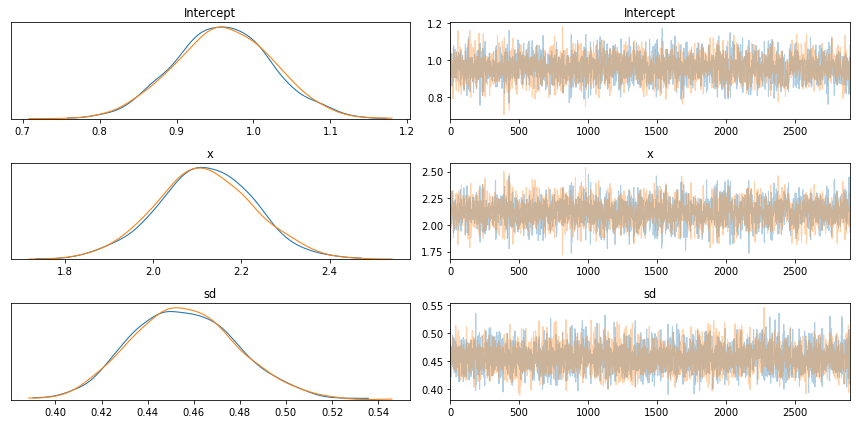

In [11]:
import warnings
warnings.filterwarnings('ignore')

# posterior plots
plt.figure(figsize=(7, 7))
# The trace plot shows the parameter value as a function of step number
pm.traceplot(trace[100:])
plt.tight_layout();

The left column consists of a smoothed histogram (using kernel density estimation) of the marginal posteriors of each stochastic random variable while the right column contains the samples of the Markov chain plotted in sequential order. The x variable, being vector-valued, produces two histograms and two sample traces, corresponding to both predictor coefficients.

Below is a distribution of likely regression lines.  The pymc3 GLM module gives us a set of sampled posterior regression lines.  It shows some uncertainty.  The range is narrow and the set of samples are not too far off from the "true" regression line.

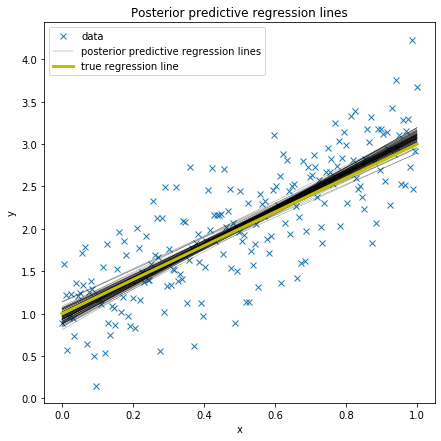

In [12]:
plt.figure(figsize=(7, 7))
plt.plot(x, y, 'x', label='data')
pm.plot_posterior_predictive_glm(trace, samples=100, 
                              label='posterior predictive regression lines')
plt.plot(x, true_regression_line, label='true regression line', lw=3., c='y')

plt.title('Posterior predictive regression lines')
plt.legend(loc=0)
plt.xlabel('x')
plt.ylabel('y');

In [ ]:
# end